In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.0-preview2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop2.7"
import findspark
findspark.init()

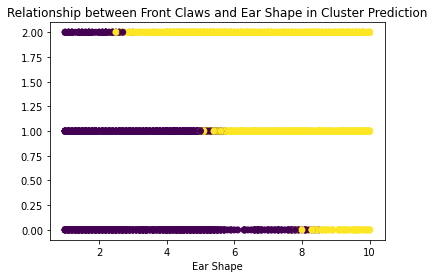

Accuracy: 79.0%


In [51]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from matplotlib import pyplot as plt

spark = SparkSession.builder.getOrCreate()

df_train = spark.read.option("inferschema","true").csv("BearTraining.csv", header=True)
df_train = df_train.select("Front Claws", "Hair Color", "Ear Shape")
df_train = df_train.na.drop()
df_train = df_train.withColumn("Hair Color", when(df_train["Hair Color"] == "White", 0).when(df_train["Hair Color"]=="Blond",1).when(df_train["Hair Color"]=="Cinnamon",2).when(df_train["Hair Color"]=="Light Brown",3).when(df_train["Hair Color"]=="Dark Brown",4).otherwise(5))
df_train = df_train.withColumn("Ear Shape", when(df_train["Ear Shape"] == "Pointed", 0).when(df_train["Ear Shape"]=="Broad",1).otherwise(2))

col_train = df_train.columns
df_train = VectorAssembler(inputCols = col_train, outputCol = "Vector").transform(df_train)

scaler_train = StandardScaler(inputCol = "Vector", outputCol="features")
df_train = scaler_train.fit(df_train).transform(df_train)

df_test = spark.read.option("inferschema","true").csv("BearTesting.csv", header=True)
df_test = df_test.select("Front Claws", "Hair Color", "Ear Shape", "Grizzly")
df_test = df_test.na.drop()
df_test = df_test.withColumn("Hair Color", when(df_test["Hair Color"] == "White", 0).when(df_test["Hair Color"]=="Blond",1).when(df_test["Hair Color"]=="Cinnamon",2).when(df_test["Hair Color"]=="Light Brown",3).when(df_test["Hair Color"]=="Dark Brown",4).otherwise(5))
df_test = df_test.withColumn("Ear Shape", when(df_test["Ear Shape"] == "Pointed", 0).when(df_test["Ear Shape"]=="Broad",1).otherwise(2))
df_test = df_test.withColumn("Grizzly", when(df_test["Grizzly"] == "Yes", 1).otherwise(0))

col_test = df_test.columns
col_test.remove("Grizzly")
df_test = VectorAssembler(inputCols = col_test, outputCol = "Vector").transform(df_test)

scaler_test = StandardScaler(inputCol = "Vector", outputCol="features")
df_test = scaler_test.fit(df_test).transform(df_test)

kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(df_train)
predictions = model.transform(df_test)

#Visualization
predictions = predictions.toPandas()
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(predictions["Front Claws"], predictions["Ear Shape"], c = predictions["prediction"])
ax.set_title('Relationship between Front Claws and Ear Shape in Cluster Prediction')
ax.set_xlabel('Front Claws')
ax.set_xlabel('Ear Shape')
plt.show()

c = 0
for index, row in predictions.iterrows():
  if row["Grizzly"] == row["prediction"]:
    c = c + 1

print("Accuracy: {}%".format(c / len(predictions)*100))